In [1]:
from optyx import channel, zx
from optyx.channel import Channel, Measure, Discard, Bra
from optyx.channel import qubit, qmode, bit, mode
from optyx.lo import BS_hadamard
from optyx.optyx import DualRail, Scalar, Mode, Bit
from optyx.feed_forward.classical_control import (
    ClassicalFunctionBox,
    ControlChannel
)

def success_value(x):
    a, b = x[0], x[1]
    return [(a % 2) ^ (b % 2)]

success_function = ControlChannel(
    ClassicalFunctionBox(
        success_value,
        Mode(2),
        Bit(1)
    )
)

def fusion_function(x):
    """
    A classical function that returns two bits based on an input x,
    based on the classical logical for the Fusion type II circuit.
    """
    a = x[0]
    b = x[1]
    c = x[2]
    d = x[3]
    s = (a % 2) ^ (b % 2)
    k = int(s*(b + d) + (1-s)*(1 - (a + b)/2))%2
    return [s, k]

classical_function = ControlChannel(
    ClassicalFunctionBox(
        fusion_function,
        Mode(4),
        Bit(2)
    )
)

correction_value = ControlChannel(ClassicalFunctionBox(lambda x: [(x[0] + x[1])%2], Mode(2), Bit(1)))
BS_channel = Channel('BS', BS_hadamard)
dual_rail = lambda state: Channel("DualRail", DualRail(internal_state=state))
decode = Channel('Decode', DualRail().dagger(), dom = mode ** 2, cod = bit)
bell_state = Channel('Bell', zx.Z(0, 2) @ Scalar(0.5 ** 0.5))

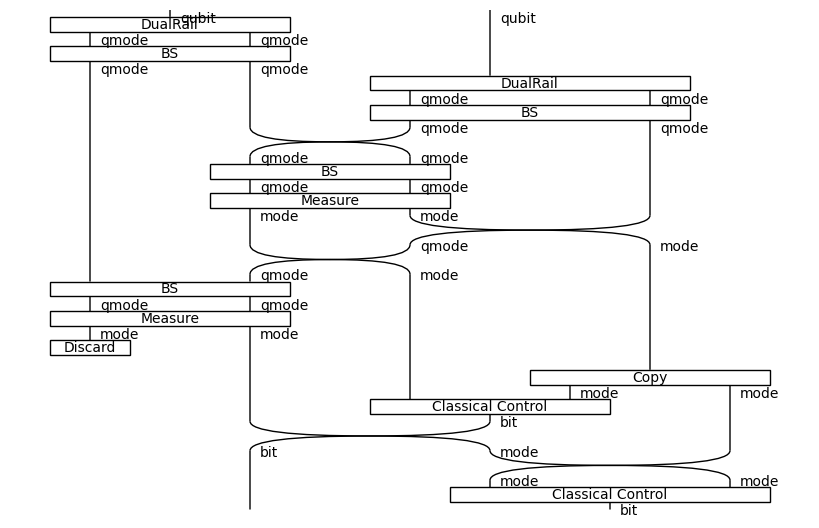

In [12]:
import numpy as np
from optyx import optyx

def qubit_fusion(state1, state2):
    @Channel.from_callable(dom=qubit @ qubit, cod=bit @ bit)
    def result(a, b):
        qm1, qm2 = BS_channel(*dual_rail(state1)(a))
        qm3, qm4 = BS_channel(*dual_rail(state2)(b))
        m1, m2 = Measure(qmode ** 2)(*BS_channel(qm3, qm2))
        m3, m4 = Measure(qmode ** 2)(*BS_channel(qm1, qm4))
        Discard(mode)(m3)
        m2_0, m2_1 = Channel('Copy', optyx.Spider(1, 2, Mode(1)), dom=mode, cod=mode ** 2)(m2)
        s = success_function(m1, m2_0)
        k = correction_value(m2_1, m4)
        return s, k
    return result

def bell_state_preparation(state1, state2):
    box = qubit_fusion(state1, state2)
    @Channel.from_callable(dom=channel.Ty(), cod= qubit @ qubit)
    def result():
        a, b = bell_state()
        c, d = bell_state()
        s, k =  box(b, c)
        Bra(1, dom=bit)(s)
        Bra(0, dom=bit)(k)
        return a, d
    return result

internal_state_1 = [1, 0]
internal_state_2 = [0.8, 0.2] / np.linalg.norm([0.8, 0.2])
qubit_fusion(internal_state_1, internal_state_2).draw(figsize=(8, 5))

In [3]:
success_probability = bell_state_preparation(internal_state_1, internal_state_2) >> Discard(qubit ** 2)
assert np.isclose(success_probability.double().to_zw().to_tensor().to_quimb()^..., 0.25)
inner_product = bell_state_preparation(internal_state_1, internal_state_2) >> bell_state.dagger()
f = inner_product.inflate(2).double().to_zw().to_tensor(max_dim=3).to_quimb()^...
n = success_probability.inflate(2).double().to_zw().to_tensor(max_dim=3).to_quimb()^...
print(f/n)

0.970588235294118


In [4]:
import math

def rotated_unit_vectors(n: int = 10):
    for i in range(n):
        theta = i * (math.pi / 2) / (n - 1)
        yield (math.cos(theta), math.sin(theta))

fidelities = []
inner_product_states = []

for vector in rotated_unit_vectors(10):
    success_probability = bell_state_preparation(internal_state_1, vector) >> Discard(qubit ** 2)
    inner_product = bell_state_preparation(internal_state_1, vector) >> bell_state.dagger()
    f = inner_product.inflate(2).double().to_zw().to_tensor(max_dim=3).to_quimb()^...
    n = success_probability.inflate(2).double().to_zw().to_tensor(max_dim=3).to_quimb()^...
    fidelities += [f/n]
    print(f/n)
    inner_product_states.append(np.inner(vector, internal_state_1))

1.0000000000000002
0.9849231551964771
0.9415111107797446
0.8750000000000002
0.7934120444167327
0.7065879555832676
0.6250000000000001
0.5584888892202557
0.515076844803523
0.5000000000000001


In [26]:
from optyx import optyx

@optyx.Diagram.from_callable(dom=optyx.bit ** 2, cod =optyx.bit)
def cnot(a, b):
    x, y = zx.Z(1, 2)(a)
    z = zx.X(2, 1)(y, b)
    optyx.Scalar(2**0.5)()
    return 
cnot.to_tensor().eval()

Tensor[complex128]([1.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 1.+0.j], dom=Dim(2, 2), cod=Dim(2))